In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from numpy import mean
from sklearn import svm
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

import warnings

In [3]:
from DataPreparation import DataPreparation

In [4]:
pics = './images'

In [5]:
df = pd.read_csv('./data/balanced_dataframe.csv', index_col=None)
df.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MaxPartialCharge,MinPartialCharge,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,...,fr_Nhpyrrole,fr_aldehyde,fr_amidine,fr_aryl_methyl,fr_benzene,fr_benzodiazepine,fr_diazo,fr_halogen,fr_hdrzine,label
0,10.337455,-1.272753,23.375000,505.329,79.918731,10.123678,9.103951,-0.051090,3.459112,1.375036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,10.335047,-1.271941,23.375000,505.329,79.918731,10.124302,9.103026,-0.051090,3.450909,1.367373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,10.333078,-1.271281,23.375000,505.329,79.918731,10.124439,9.103025,-0.051090,3.448581,1.360843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10.355554,-1.235039,25.218750,440.504,16.562573,9.897992,5.825210,-0.051059,3.346646,1.323034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,6.090409,0.226017,12.285714,362.614,79.918731,10.103988,9.101988,0.552888,3.020157,1.976391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [6]:
X = df.drop(columns=['label'])
y = df['label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y
                                                    )
y_test.value_counts()

0    915
1    915
Name: label, dtype: int64

In [8]:
data_preparation = DataPreparation(X_train, X_test, y_train, y_test)

# # get scaled clean data
# # use StandartScaler
X_train, X_test, y_train, y_test = data_preparation.clean_dataset()

## Feature selection

### Feature selection using Random Forest Classifier

In [9]:
Rtree_clf = RandomForestClassifier()
Rtree_clf = Rtree_clf.fit(X_train,y_train)
model = SelectFromModel(Rtree_clf, prefit=True)
RF_tree_featuresTrain = X_train.loc[:, model.get_support()]
RF_tree_featuresTest = X_test.loc[:, model.get_support()]
warnings.filterwarnings('ignore')

importances = Rtree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rtree_clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
indices.shape
indices = indices[:200]

In [10]:
print(len(importances[indices]))

83


In [24]:
indices[:20]

array([39, 27,  6, 32, 17, 73, 51, 12, 24,  2, 71,  7,  5,  1, 49, 62, 34,
        4, 57, 42])

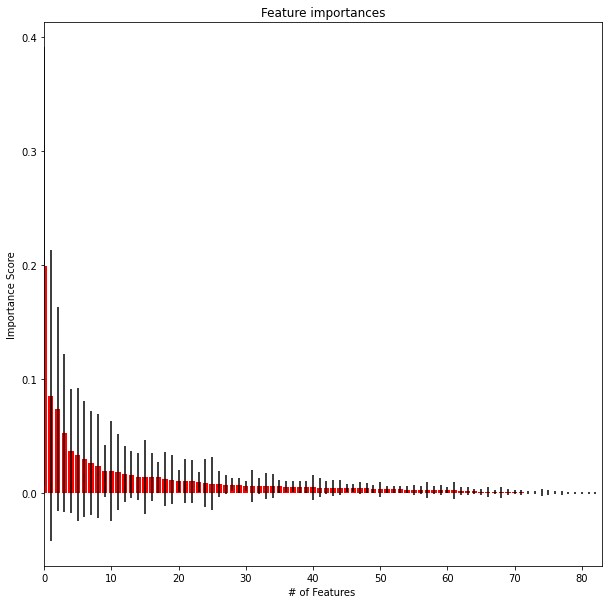

In [12]:
plt.figure(1, figsize=(10, 10))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(len(importances[indices])), importances[indices], color="r", yerr=std[indices], align="center")
plt.xlim([0, len(importances[indices])])
plt.show()
# plt.savefig(f'{pics}/rf_feat_import.png')

### 1.13.3. Recursive Feature Elmination

In [13]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [15]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10)
min_features_to_select = 10
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

size = 6050
rfecv.fit(X[:size], y[:size])
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 93


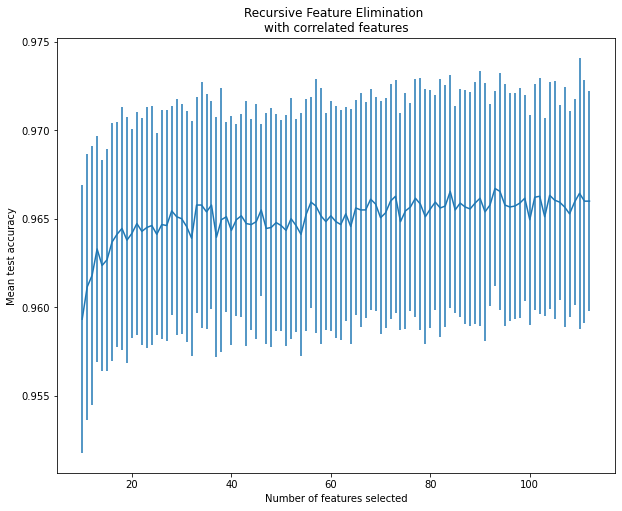

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()
# plt.savefig(f'{pics}/rfe_with_corr_feat.png')

### Applying RFE with optimal number of features found in RFECV

In [17]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10)
rfe = RFE(estimator=clf, n_features_to_select=rfecv.n_features_, step=1)
rfe = rfe.fit(X_train, y_train)

In [18]:
rfe_train = pd.DataFrame(X_train).loc[:, rfe.get_support()]
rfe_test = pd.DataFrame(X_test).loc[:, rfe.get_support()]

print("Train Accuracy:",cross_val_score(clf,rfe_train,y_train, cv=5).mean())

clf = clf.fit(rfe_train, y_train)
y_pred = clf.predict(rfe_test)
print("Test Accuracy:", accuracy_score(y_pred, y_test))

print(classification_report(y_test, y_pred))

Train Accuracy: 0.962295081967213
Test Accuracy: 0.966120218579235
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       915
           1       0.95      0.99      0.97       915

    accuracy                           0.97      1830
   macro avg       0.97      0.97      0.97      1830
weighted avg       0.97      0.97      0.97      1830



,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.559602,0.611651,-0.422226,1.211841,-0.585803,0.059382,-0.137254,1.054514,-1.179718,0.135853,...,-0.594943,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,-0.195439,-0.337585
1,0.428572,0.503159,-0.942970,-0.375029,0.310526,0.386482,0.709755,0.766113,-0.162462,-0.134427,...,1.645274,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,-0.195439,-0.337585
2,-2.415560,0.933966,-0.864290,-1.419216,0.500732,0.417429,1.502564,-0.105369,0.984164,-0.136860,...,-0.594943,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,-0.195439,-0.337585
3,-0.573217,-0.226000,0.976004,0.700514,-0.580937,0.172790,0.014556,0.683626,-0.530271,-0.111818,...,1.645274,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,20.096993,-0.337585
4,0.450529,0.336894,-0.687366,0.318551,-0.573277,0.523207,0.547022,1.281237,-1.038073,-0.097077,...,-0.594943,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,-0.195439,2.823571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4265,0.348495,0.193469,-0.614622,-0.742899,-0.582433,-0.017473,0.299106,-1.033241,0.500648,-0.136435,...,-0.594943,-0.390064,-0.33739,-0.383465,-0.328506,-0.384748,-0.337718,-0.299921,-0.195439,-0.337585
4266,-2.364028,0.909576,0.097230,0.385453,-0.586832,-0.131133,0.466740,1.210082,-1.095518,-0.107162,...,-0.594943,-0.390064,-0.33739,-0.383465,2.522551,-0.384748,-0.337718,-0.299921,-0.195439,-0.337585
4267,0.687308,0.651540,0.025443,1.644715,-0.584946,0.017749,-2.136747,1.607623,-0.724821,0.778785,...,-0.594943,3.165055,-0.33739,-0.383465,-0.328506,2.146648,2.611272,-0.299921,-0.195439,-0.337585
4268,-2.770428,0.629819,0.874111,0.675092,-0.629051,-0.145403,-1.961119,0.392894,-1.000049,-0.042477,...,1.645274,-0.390064,-0.33739,3.464706,-0.328506,-0.384748,2.611272,-0.299921,-0.195439,-0.337585


### Permutation importance

In [21]:
svc = svm.SVC(C=1, gamma=0.0001, random_state=0)
svc.fit(X_train, y_train)
perm_importance = permutation_importance(svc, X_test, y_test, n_jobs=-1)
features = np.array(X.columns)
sorted_idx = perm_importance.importances_mean.argsort()

#### Plot top 10 most important features

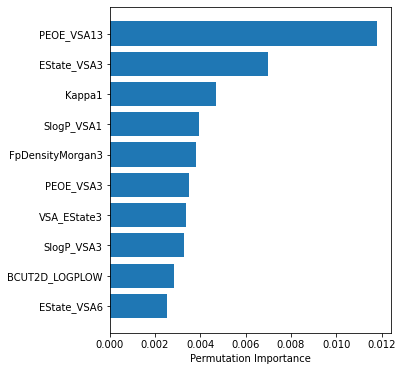

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][-10:], perm_importance.importances_mean[sorted_idx][-10:])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.show()
# plt.savefig(f'{pics}/top10_feat_perm.png')

#### Plot top 10 less important features

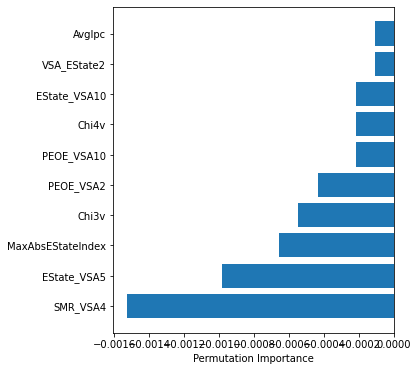

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][:10], perm_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.show()
# plt.savefig(f'{pics}/top-10_feat_perm.png')

In [26]:
### Top 20 most important
for x in features[[39, 27,  6, 32, 17, 73, 51, 12, 24,  2, 71,  7,  5,  1, 49, 62, 34,
        4, 57, 42]]:
    print(x)

PEOE_VSA13
Chi3v
FpDensityMorgan3
Kappa1
BertzCT
EState_VSA3
SMR_VSA4
BCUT2D_LOGPLOW
Chi2n
qed
EState_VSA11
BCUT2D_MWHI
MinPartialCharge
MinAbsEStateIndex
SMR_VSA2
SlogP_VSA3
Kappa3
MaxPartialCharge
SlogP_VSA1
PEOE_VSA3
